# H4 — Odds altas para empate e comportamento de gols

Este notebook segue o plano descrito em `plano_testes_hipotese.md` para investigar como odds elevadas de empate (Bet365) se relacionam com a distribuição de gols e a taxa real de empates na Premier League entre 2019 e 2025.

In [1]:
from pathlib import Path

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportion_confint, proportions_ztest

pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.3f}".format)

DATA_PATH = Path("data/premier_completo_19_25.csv")

selected_features = [
    "Div","Date","Time","HomeTeam","AwayTeam","FTHG","FTAG","FTR","HTHG","HTAG","HTR","Referee",
    "HS","AS","HST","AST","HC","AC","HF","AF","HY","AY","HR","AR","B365H","B365D","B365A",
    "PSD","PSA","PSH","MaxH","MaxD","MaxA","AvgH","AvgD","AvgA","B365>2.5","B365<2.5","P>2.5","P<2.5",
    "Max>2.5","Max<2.5","Avg>2.5","Avg<2.5","B365AHH","B365AHA","PAHH","PAHA","MaxAHH","MaxAHA","AvgAHH","AvgAHA"
]

df_full = pd.read_csv(DATA_PATH, dayfirst=True)

assert set(df_full.columns) == set(selected_features), "Colunas do CSV fora do esperado"

df_full["Date"] = pd.to_datetime(df_full["Date"], dayfirst=True)
df_full["FTR"] = df_full["FTR"].astype("category")

categorical_cols = ["Div","Time","HomeTeam","AwayTeam","FTR","HTR","Referee"]
numeric_columns = df_full.columns.difference(categorical_cols + ["Date"])
df_full[numeric_columns] = df_full[numeric_columns].apply(pd.to_numeric, errors="coerce")

df_full.head()

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,PSH,PSD,PSA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,P>2.5,P<2.5,Max>2.5,Max<2.5,Avg>2.5,Avg<2.5,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA
0,E0,2019-08-09,20:00,Liverpool,Norwich,4,1,H,4,0,H,M Oliver,15,12,7,5,9,9,11,2,0,2,0,0,1.140,10.000,19.000,1.150,9.590,18.050,1.160,10.000,23.000,1.140,8.750,19.830,1.400,3.000,1.400,3.110,1.450,3.110,1.410,2.920,1.960,1.940,1.970,1.950,1.970,2.000,1.940,1.940
1,E0,2019-08-10,12:30,West Ham,Man City,0,5,A,0,1,A,M Dean,5,14,3,9,6,13,1,1,2,2,0,0,12.000,6.500,1.220,11.680,6.530,1.260,13.000,6.750,1.290,11.840,6.280,1.250,1.440,2.750,1.490,2.770,1.510,2.770,1.480,2.650,2.000,1.900,2.020,1.900,2.020,1.920,1.990,1.890
2,E0,2019-08-10,15:00,Bournemouth,Sheffield United,1,1,D,0,0,D,K Friend,13,8,3,3,10,19,3,4,2,1,0,0,1.950,3.600,3.600,2.040,3.570,3.900,2.060,3.650,4.000,2.010,3.530,3.830,1.900,1.900,1.960,1.960,2.000,1.990,1.900,1.930,2.010,1.890,2.040,1.880,2.040,1.910,2.000,1.880
3,E0,2019-08-10,15:00,Burnley,Southampton,3,0,H,0,0,D,G Scott,10,11,4,3,6,12,2,7,0,0,0,0,2.620,3.200,2.750,2.710,3.310,2.810,2.800,3.330,2.850,2.680,3.220,2.780,2.100,1.720,2.170,1.770,2.200,1.780,2.120,1.730,1.920,1.980,1.930,2.000,1.940,2.000,1.910,1.980
4,E0,2019-08-10,15:00,Crystal Palace,Everton,0,0,D,0,0,D,J Moss,6,10,2,3,16,14,6,2,2,1,0,1,3.000,3.250,2.370,3.210,3.370,2.390,3.210,3.400,2.520,3.130,3.270,2.400,2.200,1.660,2.230,1.740,2.250,1.740,2.180,1.700,1.850,2.050,1.880,2.050,1.880,2.090,1.840,2.040


In [2]:
# Preparação inicial
df_analysis = (
    df_full[
        [
            "Date","HomeTeam","AwayTeam","FTHG","FTAG","FTR","B365D","PSD","PSA","B365H","B365A"
        ]
    ]
    .dropna(subset=["B365D","FTHG","FTAG"])
    .copy()
 )
 
df_analysis["total_goals"] = df_analysis["FTHG"] + df_analysis["FTAG"]
df_analysis["goal_diff"] = (df_analysis["FTHG"] - df_analysis["FTAG"]).abs()
df_analysis["is_draw"] = (df_analysis["FTR"] == "D").astype(int)
 
q1, q3 = df_analysis["B365D"].quantile([0.25, 0.75])
 
def classify_draw_odds(value: float) -> str:
    if value <= q1:
        return "baixa"
    if value >= q3:
        return "alta"
    return "media"
 
df_analysis["draw_odds_group"] = df_analysis["B365D"].apply(classify_draw_odds)
 
group_counts = df_analysis["draw_odds_group"].value_counts().sort_index()
group_counts

draw_odds_group
alta      617
baixa     746
media    1089
Name: count, dtype: int64

In [3]:
# Estatísticas descritivas por faixa de odds
summary_stats = (
    df_analysis.groupby("draw_odds_group")
    .agg(
        partidas=("draw_odds_group", "size"),
        odds_media=("B365D", "mean"),
        gols_medios=("total_goals", "mean"),
        desvio_gols=("total_goals", "std"),
        diferença_media=("goal_diff", "mean"),
        taxa_empates=("is_draw", "mean")
    )
    .sort_index()
)
 
summary_stats

,partidas,odds_media,gols_medios,desvio_gols,diferença_media,taxa_empates
draw_odds_group,,,,,,
alta,617,5.751,3.267,1.754,1.887,0.162
baixa,746,3.287,2.375,1.493,1.099,0.295
media,1089,3.746,2.777,1.653,1.374,0.246


C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_8272\3200642066.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_analysis, x="draw_odds_group", y="total_goals", palette=palette, order=["baixa","media","alta"])


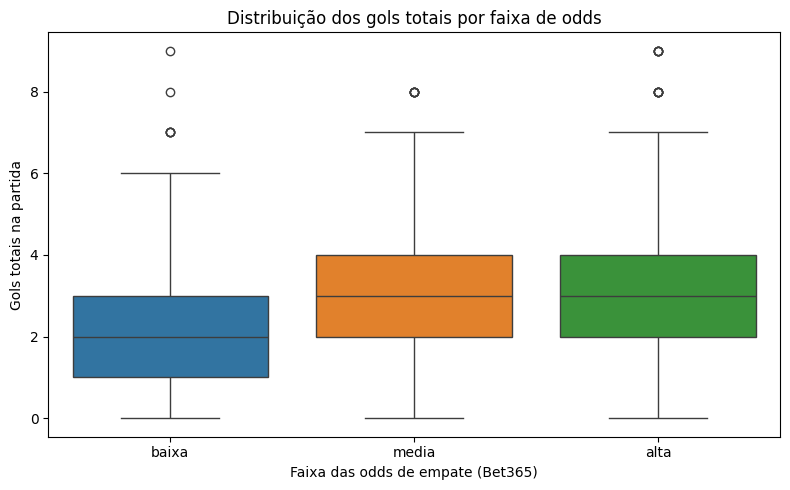

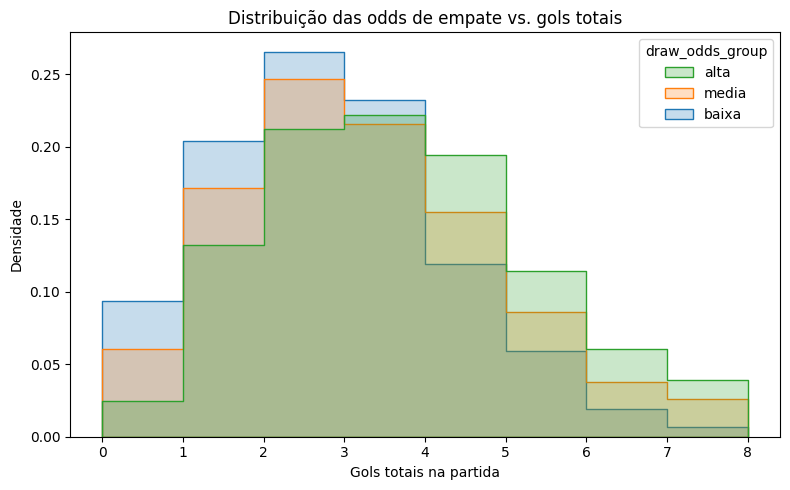

In [4]:
# Visualizações das distribuições
palette = {"baixa": "#1f77b4", "media": "#ff7f0e", "alta": "#2ca02c"}
 
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_analysis, x="draw_odds_group", y="total_goals", palette=palette, order=["baixa","media","alta"])
plt.xlabel("Faixa das odds de empate (Bet365)")
plt.ylabel("Gols totais na partida")
plt.title("Distribuição dos gols totais por faixa de odds")
plt.tight_layout()
plt.show()
 
plt.figure(figsize=(8, 5))
sns.histplot(data=df_analysis, x="total_goals", hue="draw_odds_group", palette=palette, element="step", stat="density", common_norm=False, bins=range(0,9))
plt.xlabel("Gols totais na partida")
plt.ylabel("Densidade")
plt.title("Distribuição das odds de empate vs. gols totais")
plt.tight_layout()
plt.show()

In [5]:
# Testes de normalidade (amostras de até 500 observações) e homocedasticidade
normality_results = []
for metric in ["total_goals", "goal_diff"]:
    for group, group_df in df_analysis.groupby("draw_odds_group"):
        sample = group_df[metric]
        sample_for_shapiro = sample if len(sample) <= 500 else sample.sample(500, random_state=42)
        stat, p_value = stats.shapiro(sample_for_shapiro)
        normality_results.append({
            "metrica": metric,
            "grupo": group,
            "estatistica": stat,
            "p_valor": p_value
        })
 
normality_df = pd.DataFrame(normality_results).sort_values(["metrica", "grupo"])
 
levene_total = stats.levene(
    *[group["total_goals"].values for _, group in df_analysis.groupby("draw_odds_group")],
    center="median"
 )
levene_diff = stats.levene(
    *[group["goal_diff"].values for _, group in df_analysis.groupby("draw_odds_group")],
    center="median"
 )
 
normality_df, levene_total, levene_diff

(       metrica  grupo  estatistica  p_valor
 3    goal_diff   alta        0.881    0.000
 4    goal_diff  baixa        0.844    0.000
 5    goal_diff  media        0.868    0.000
 0  total_goals   alta        0.945    0.000
 1  total_goals  baixa        0.941    0.000
 2  total_goals  media        0.934    0.000,
 LeveneResult(statistic=np.float64(7.678688637545373), pvalue=np.float64(0.00047380592392760407)),
 LeveneResult(statistic=np.float64(48.19692353872043), pvalue=np.float64(2.9497293738841286e-21)))

In [9]:
# Testes globais e pós-hoc
ordered_labels = ["baixa", "media", "alta"]
groups_total = [df_analysis.loc[df_analysis["draw_odds_group"] == label, "total_goals"] for label in ordered_labels]
groups_diff = [df_analysis.loc[df_analysis["draw_odds_group"] == label, "goal_diff"] for label in ordered_labels]
 
normality_pass = (
    normality_df.loc[normality_df["metrica"] == "total_goals", "p_valor"] > 0.05
).all()
homoscedastic = levene_total.pvalue > 0.05
 
def eta_squared_anova(series_groups):
    combined = np.concatenate([series.values for series in series_groups])
    overall_mean = combined.mean()
    ss_between = sum(len(series) * (series.mean() - overall_mean) ** 2 for series in series_groups)
    ss_total = sum(((series - overall_mean) ** 2).sum() for series in series_groups)
    return ss_between / ss_total if ss_total > 0 else np.nan
 
def eta_squared_kruskal(statistic: float, n_obs: int, k_groups: int) -> float:
    return (statistic - k_groups + 1) / (n_obs - k_groups) if n_obs > k_groups else np.nan
 
def cliffs_delta(x: pd.Series, y: pd.Series) -> float:
    """
    Calcula o Cliff's delta, medida de tamanho de efeito para dados ordinais.
    Retorna valor entre -1 e +1:
    - Positivo: x tende a ter valores maiores que y
    - Negativo: y tende a ter valores maiores que x
    - 0: distribuições similares
    """
    m, n = len(x), len(y)
    if m == 0 or n == 0:
        return np.nan
    
    # Conta quantos pares (xi, yj) satisfazem xi > yj e xi < yj
    maior = sum(xi > yj for xi in x for yj in y)
    menor = sum(xi < yj for xi in x for yj in y)
    
    return (maior - menor) / (m * n)
 
if normality_pass and homoscedastic:
    test_name = "ANOVA"
    test_result = stats.f_oneway(*groups_total)
    effect_size = eta_squared_anova(groups_total)
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
 
    posthoc = pairwise_tukeyhsd(
        endog=df_analysis["total_goals"],
        groups=df_analysis["draw_odds_group"],
        alpha=0.05
    )
    posthoc_table = pd.DataFrame(posthoc.summary().data[1:], columns=posthoc.summary().data[0])
else:
    test_name = "Kruskal-Wallis"
    test_result = stats.kruskal(*groups_total)
    effect_size = eta_squared_kruskal(test_result.statistic, len(df_analysis), len(groups_total))
    try:
        import scikit_posthocs as sp
 
        posthoc_table = sp.posthoc_dunn(
            df_analysis, val_col="total_goals", group_col="draw_odds_group", p_adjust="holm"
        )
    except ImportError:
        from statsmodels.stats.multitest import multipletests
 
        raw_p = []
        comparisons = []
        for g1, g2 in itertools.combinations(ordered_labels, 2):
            stat_mw, p_mw = stats.mannwhitneyu(
                df_analysis.loc[df_analysis["draw_odds_group"] == g1, "total_goals"],
                df_analysis.loc[df_analysis["draw_odds_group"] == g2, "total_goals"],
                alternative="two-sided"
            )
            comparisons.append(f"{g1} vs {g2}")
            raw_p.append(p_mw)
        reject, p_adj, _, _ = multipletests(raw_p, method="holm")
        posthoc_table = pd.DataFrame(
            {
                "comparacao": comparisons,
                "p_valor_bruto": raw_p,
                "p_valor_ajustado": p_adj,
                "rejeita_H0": reject
            }
        )
 
delta_alta_baixa = cliffs_delta(
    df_analysis.loc[df_analysis["draw_odds_group"] == "alta", "total_goals"],
    df_analysis.loc[df_analysis["draw_odds_group"] == "baixa", "total_goals"]
)
 
test_name, test_result, effect_size, posthoc_table, delta_alta_baixa

('Kruskal-Wallis',
 KruskalResult(statistic=np.float64(87.83393556937297), pvalue=np.float64(8.45479786741125e-20)),
 np.float64(0.03504856495278602),
        comparacao  p_valor_bruto  p_valor_ajustado  rejeita_H0
 0  baixa vs media          0.000             0.000        True
 1   baixa vs alta          0.000             0.000        True
 2   media vs alta          0.000             0.000        True,
 0.28955292624956)

In [7]:
# Teste de independência para a taxa de empates
contingency = pd.crosstab(df_analysis["draw_odds_group"], df_analysis["is_draw"]).sort_index()
chi2_stat, chi2_p, chi2_dof, chi2_expected = stats.chi2_contingency(contingency)
n_total = contingency.to_numpy().sum()
min_dim = min(contingency.shape) - 1
cramers_v = np.sqrt(chi2_stat / (n_total * min_dim)) if min_dim > 0 else np.nan
 
draw_high = contingency.loc["alta", 1]
draw_low = contingency.loc["baixa", 1]
n_high = contingency.loc["alta"].sum()
n_low = contingency.loc["baixa"].sum()
z_stat, z_p = proportions_ztest([draw_high, draw_low], [n_high, n_low])
 
contingency, chi2_stat, chi2_p, cramers_v, z_stat, z_p

(is_draw            0    1
 draw_odds_group          
 alta             517  100
 baixa            526  220
 media            821  268,
 np.float64(33.11061456817331),
 np.float64(6.458347369208305e-08),
 np.float64(0.11620461816248646),
 np.float64(-5.758962136523401),
 np.float64(8.46326819988123e-09))

In [10]:
# Síntese interpretativa automática
alpha = 0.05
 
interpretation = []
interpretation.append(f"Teste global utilizado: {test_name} (p-valor = {test_result.pvalue:.4f}).")
if test_result.pvalue < alpha:
    interpretation.append("Rejeitamos H0: as médias de gols totais diferem entre as faixas de odds.")
else:
    interpretation.append("Não rejeitamos H0: as médias de gols totais não diferem estatisticamente entre as faixas.")
 
if not np.isnan(effect_size):
    interpretation.append(f"Tamanho de efeito estimado (eta²): {effect_size:.3f}.")
 
# Interpretação do Cliff's delta
interpretation.append(
    f"Cliff's delta entre odds altas vs. baixas: {delta_alta_baixa:.3f}."
)
if delta_alta_baixa > 0.28:
    interpretation.append("  → Efeito médio: partidas com odds altas de empate tendem a ter mais gols.")
elif delta_alta_baixa > 0.11:
    interpretation.append("  → Efeito pequeno: partidas com odds altas de empate tendem a ter ligeiramente mais gols.")
elif delta_alta_baixa < -0.28:
    interpretation.append("  → Efeito médio: partidas com odds baixas de empate tendem a ter mais gols.")
elif delta_alta_baixa < -0.11:
    interpretation.append("  → Efeito pequeno: partidas com odds baixas de empate tendem a ter ligeiramente mais gols.")
else:
    interpretation.append("  → Efeito negligível: distribuições similares entre os grupos.")
 
interpretation.append(
    f"Qui-quadrado para taxa de empates: estatística = {chi2_stat:.3f}, p-valor = {chi2_p:.4f}, V de Cramér = {cramers_v:.3f}."
)
if chi2_p < alpha:
    interpretation.append("Rejeitamos H0 de independência: a taxa de empates varia entre as faixas de odds.")
else:
    interpretation.append("Não rejeitamos H0: a taxa de empates não difere de forma significativa entre as faixas.")
 
interpretation.append(
    f"Z-teste odds altas vs. baixas: estatística = {z_stat:.3f}, p-valor = {z_p:.4f}."
)
if z_p < alpha:
    interpretation.append("Empates ocorrem em proporção diferente entre odds altas e baixas.")
else:
    interpretation.append("Empates ocorrem em proporções semelhantes entre odds altas e baixas.")
 
for line in interpretation:
    print(line)

Teste global utilizado: Kruskal-Wallis (p-valor = 0.0000).
Rejeitamos H0: as médias de gols totais diferem entre as faixas de odds.
Tamanho de efeito estimado (eta²): 0.035.
Cliff's delta entre odds altas vs. baixas: 0.290.
  → Efeito médio: partidas com odds altas de empate tendem a ter mais gols.
Qui-quadrado para taxa de empates: estatística = 33.111, p-valor = 0.0000, V de Cramér = 0.116.
Rejeitamos H0 de independência: a taxa de empates varia entre as faixas de odds.
Z-teste odds altas vs. baixas: estatística = -5.759, p-valor = 0.0000.
Empates ocorrem em proporção diferente entre odds altas e baixas.


## Próximos passos
- Registrar no relatório (`relatorio_entrega1_ICD.md`) os principais achados e valores numéricos depois de executar o notebook.
- Explorar sensibilidade alterando os limites de quantis (ex.: percentis 20/80) para confirmar a robustez das conclusões.
- Replicar os testes para `PSD` (Pinnacle) caso seja necessário comparar casas de apostas.